In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from math import floor

### Hyper_parameters

In [2]:
# Set some parameters
img_size = 128  # 384
img_channels = 3
batch_size = 20

path = "./dataset/ISIC2018_Task1-2_Training_Data/" 
train_path = "./dataset/ISIC2018_Task1-2_Training_Data/images" # Training set path

## Training Ids
train_ids = []
for files in os.walk(train_path):  # Traverse directory
       for name in files:
              train_ids.append(name)

train_ids = train_ids[2]  # Get file name
train_ids = [i.split('.', 1)[0] for i in train_ids]  # remove .jpg suffix

# split whole train id into train, validate and test which follows 0.8, 0.1, 0.1 ratio
val_data_size = floor(len(train_ids) * 0.2)  # Validation set size
test_data_size = floor(val_data_size * 0.5)  # test set size

valid_test_ids = train_ids[:val_data_size]
test_ids = valid_test_ids[:test_data_size]
valid_ids = valid_test_ids[test_data_size:]

train_ids = train_ids[val_data_size:]  # Data is divided into 3 parts

There isn’t a set standard for this. For smaller datasets under 100 samples I would do a 60,20,20 split. The training set proportion can be much larger if you have a massive dataset. For 10k images you could use 9k for training, 500 for validation and 500 for testing. 

Unfortunately with small datasets, you kind of have to sacrifice the training set to properly validate your model.

In [3]:
ids=valid_ids + train_ids + test_ids
print("No. of images = ", len(ids))

print("length of train_set = ", len(train_ids))
print("length of validation_set = ", len(valid_ids))
print("length of test_set = ", len(test_ids))

No. of images =  2594
length of train_set =  2076
length of validation_set =  259
length of test_set =  259


### Generate data
The DataGenerator class is used for building generators for training and testing the model.

In [4]:
from data_generator import DataGenerator

In [5]:
generator = DataGenerator(train_ids, path, batch_size=batch_size, img_size=img_size)

# Read training pictures
x, y = generator.__getitem__(0)
print("first image shape: ", x.shape, y.shape)
x1, y1 = generator.__getitem__(1)
print("second image shape:", x1.shape, y1.shape)
if x.shape == x1.shape and y.shape == y1.shape:
    print("same!")
else:
    print("there is something wrong with resizing...")

first image shape:  (20, 128, 128, 3) (20, 128, 128, 1)
second image shape: (20, 128, 128, 3) (20, 128, 128, 1)
same!


### Verify whether the image is successfully read

random number:  3


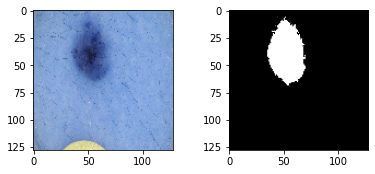

In [6]:
n = random.randint(0, len(x) - 1) # Random number within the number of pictures
print("random number: ", n)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4) # Adjust the page layout
ax = fig.add_subplot(1, 2, 1) # the first plot
ax.imshow(x[n])
ax = fig.add_subplot(1, 2, 2) # the sec plot
ax.imshow(np.reshape(y[n], (img_size, img_size)), cmap="gray")

  ### Network architecture 
  Our network is inspired by the U-Net architecture. We designed the network to process large 3D input blocks of 128x128x128 voxels. In contrast to many previous approaches who manually combined different input resolutions or pathways with varying filter sizes, the U-Net based approach allows the network to intrinsically recombine different scales throughout the entire network.  
  Just like the U-Net, our architecture comprises a context aggregation pathway that encodes increasingly abstract representations of the input as we progress deeper into the network, followed by a localization pathway that recombines these representations with shallower features to precisely localize the structures of interest. We refer to the vertical depth (the depth in the U shape) as level, with higher levels being lower spatial resolution, but higher dimensional feature representations.  
  Detailed explanation can be found: https://arxiv.org/pdf/1802.10508v1.pdf

#### Here we add dice coefficiency as our metric

In [7]:
def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool)
    y_pred = np.asarray(y_pred).astype(np.bool)
    intersection = np.logical_and(y_true, y_pred)
    return (2. * intersection.sum()) / (y_true.sum() + y_pred.sum())

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#### Build Model

In [8]:
from model_improved import improved_u_net

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 128, 128, 16) 32          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 16) 0           instance_normalization[0][0]     
_______________________________________________________________________________________

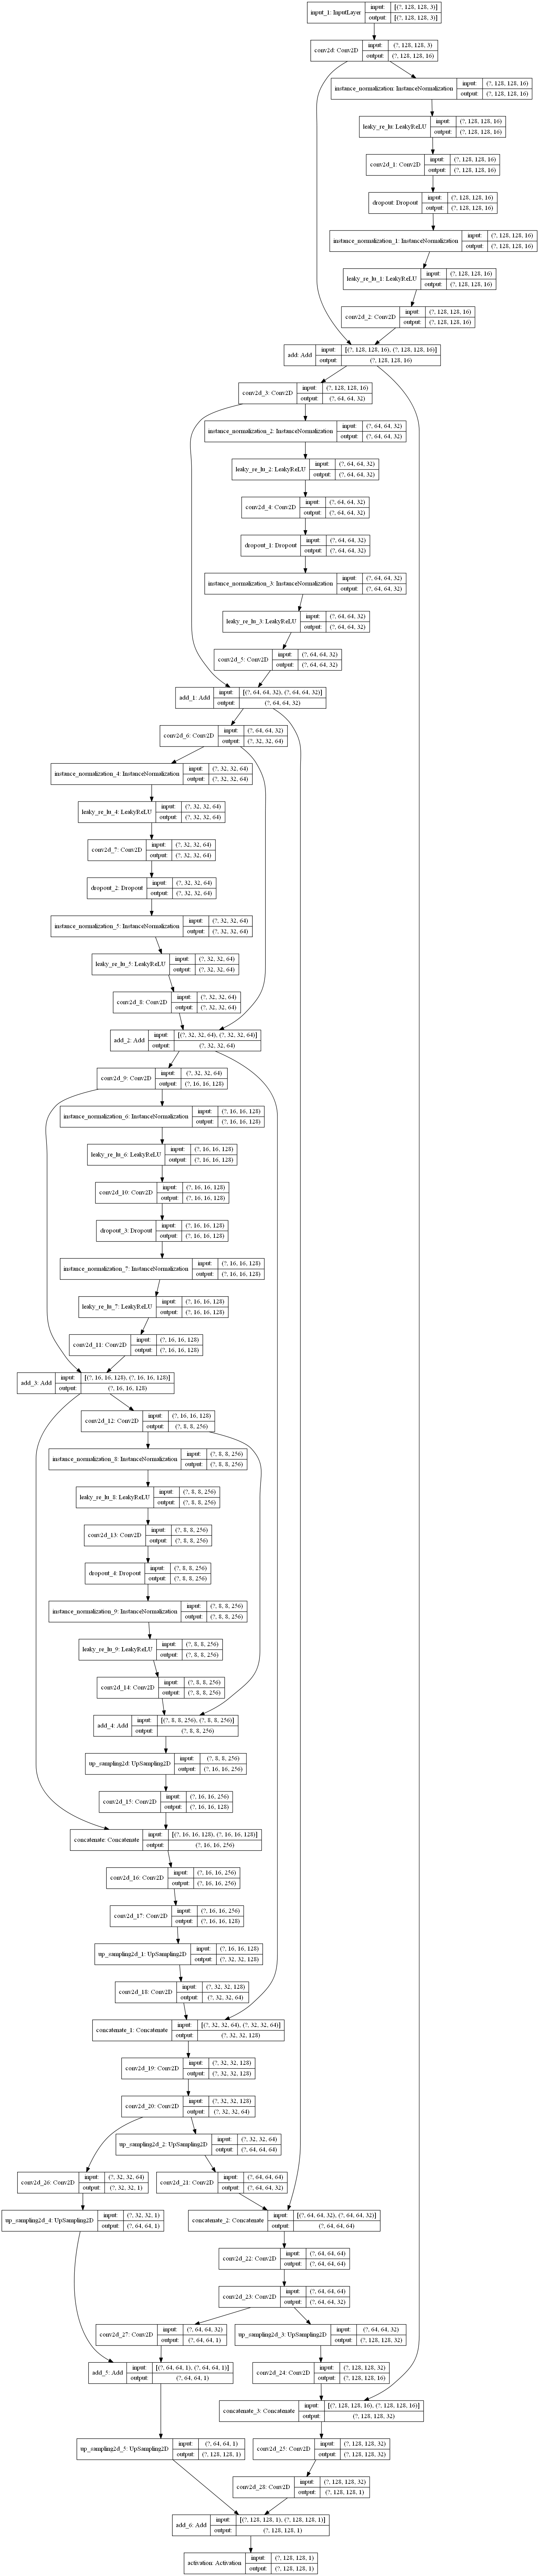

In [9]:
model = improved_u_net(img_size)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, 'accuracy'])
model_callback=tf.keras.callbacks.ModelCheckpoint(filepath='best_checkpoint', save_best_only= True,
                                                  save_weights_only=True, monitor = 'val_accuracy', mode='max')
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

### Training
Here we create the two data generator, one for the training using the training data and other using the validation data. After that we start training the model.

In [10]:
train_generator = DataGenerator(train_ids, path)
valid_generator = DataGenerator(valid_ids, path, 3, 128)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

history = model.fit(train_generator, epochs=15, validation_data=valid_generator, 
                    batch_size = batch_size, callbacks=[model_callback], verbose=1)
model.save("u_net_model_improved.h5")  # Save model

Epoch 1/15
208/208 [==============================] - 221s 1s/step - loss: 6.6782 - dice_coef: 0.4510 - accuracy: 0.8108 - val_loss: 0.5001 - val_dice_coef: 0.6472 - val_accuracy: 0.8154
Epoch 2/15
208/208 [==============================] - 222s 1s/step - loss: 0.2940 - dice_coef: 0.5758 - accuracy: 0.8963 - val_loss: 0.3383 - val_dice_coef: 0.6948 - val_accuracy: 0.8556
Epoch 3/15
208/208 [==============================] - 231s 1s/step - loss: 0.2745 - dice_coef: 0.5997 - accuracy: 0.8971 - val_loss: 0.2679 - val_dice_coef: 0.7380 - val_accuracy: 0.8855
Epoch 4/15
208/208 [==============================] - 237s 1s/step - loss: 0.2165 - dice_coef: 0.6588 - accuracy: 0.9175 - val_loss: 0.5694 - val_dice_coef: 0.6218 - val_accuracy: 0.7577
Epoch 5/15
208/208 [==============================] - 254s 1s/step - loss: 0.2034 - dice_coef: 0.6718 - accuracy: 0.9202 - val_loss: 0.2951 - val_dice_coef: 0.7042 - val_accuracy: 0.8736
Epoch 6/15
208/208 [==============================] - 259s 1s/ste

In [16]:
test_generator = DataGenerator(test_ids, path)
score = model.evaluate(test_generator)
print(score)

26/26 [==============================] - 7s 271ms/step - loss: 0.2664 - dice_coef: 0.8254 - accuracy: 0.8962
[0.26640158891677856, 0.8253787159919739, 0.8961829543113708]


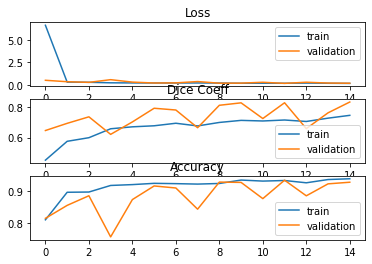

In [17]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(311)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
# plot dice during training
pyplot.subplot(312)
pyplot.title('Dice Coeff')
pyplot.plot(history.history['dice_coef'], label='train')
pyplot.plot(history.history['val_dice_coef'], label='validation')
pyplot.legend()
pyplot.subplot(313)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.savefig('resources/dice_acc_loss_improved_unet.png',bbox_inches='tight')
pyplot.show()

### Make predictions
Let's make predictions both on the test set, the val set and the train set (as a sanity check). Generates output predictions for the input samples.\
note: Remember to load the best-saved model if you've used early stopping.
***return***: Numpy array(s) of predictions.

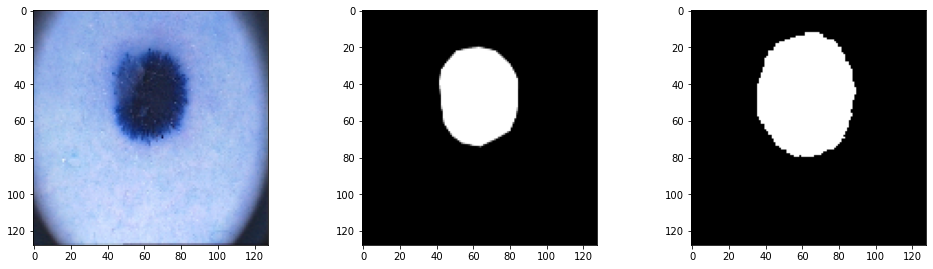

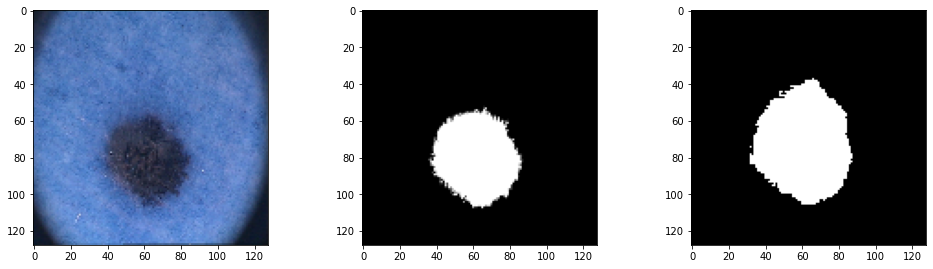

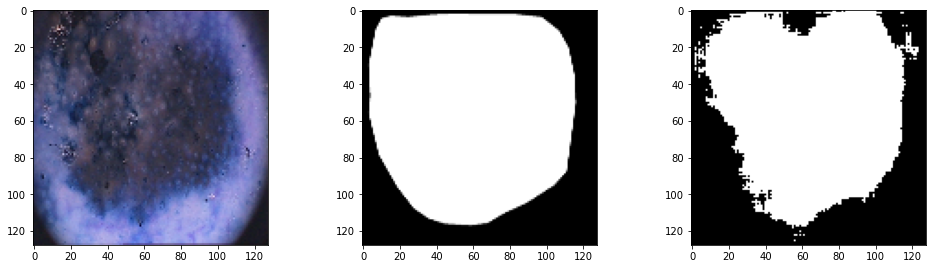

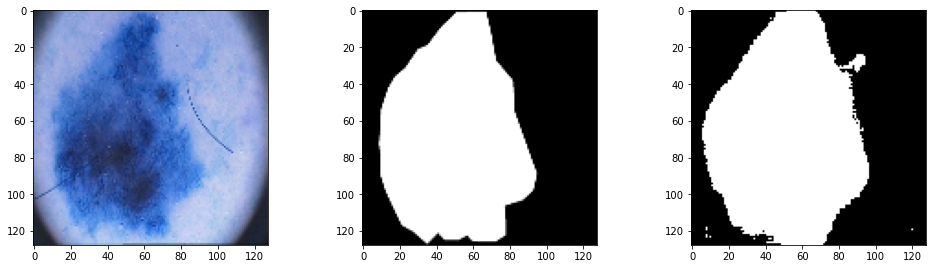

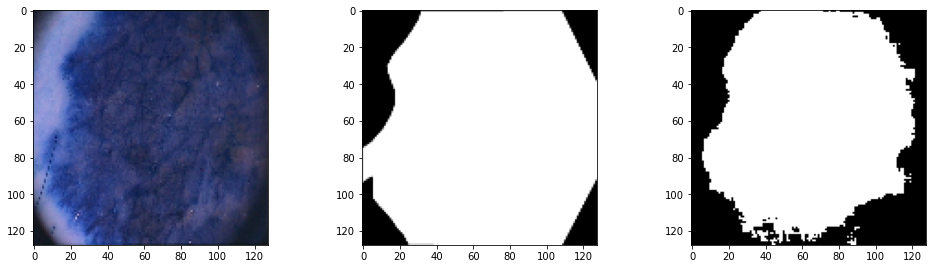

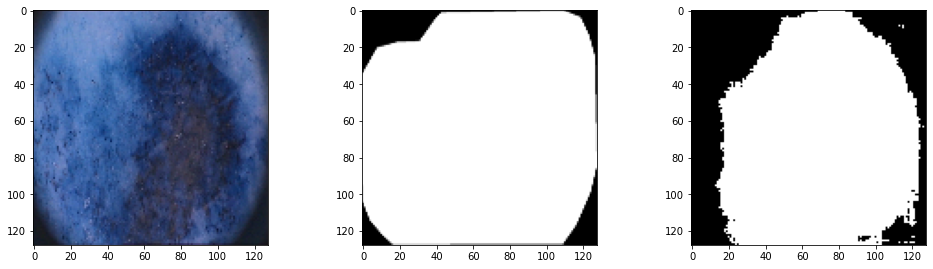

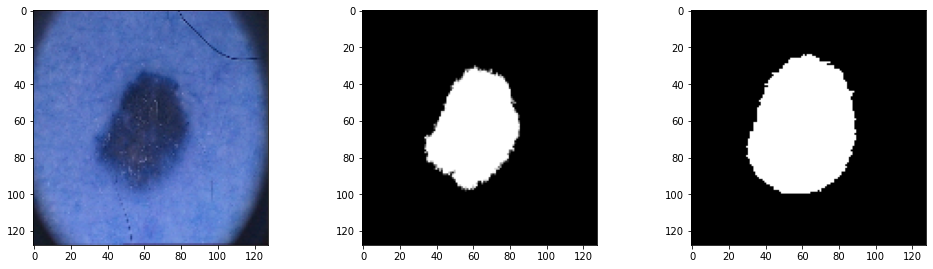

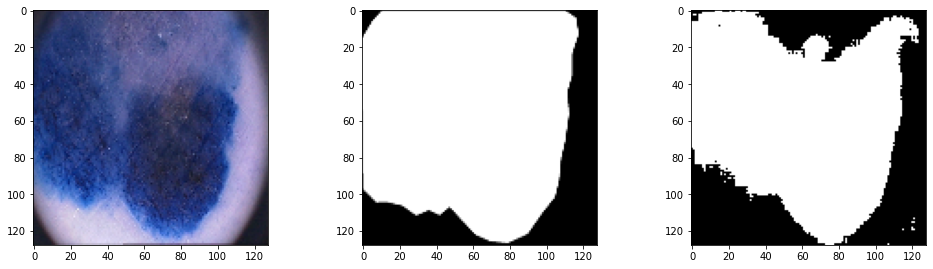

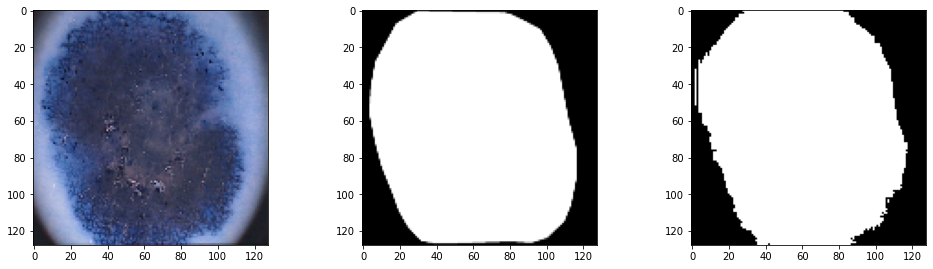

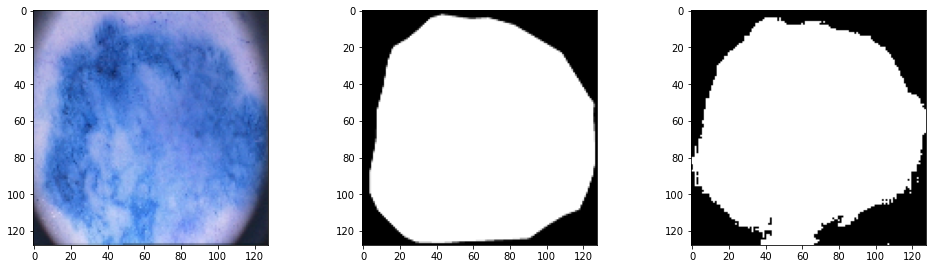

In [18]:
for i in range(0,10):
    x, y = valid_generator.__getitem__(i)
    result = model.predict(x)
    
    result = result > 0.5
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y[0]*255, (img_size, img_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(result[0]*255, (img_size, img_size)), cmap="gray")

## Evaluation

### Goal Metric

Predicted responses are scored using a threshold [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) metric.

To compute this metric:

* For each image, a pixel-wise comparison of each predicted segmentation with the corresponding ground truth segmentation is made using the Jaccard index.
* The final score for each image is computed as a threshold of the Jaccard according to the following:
  * score = 0, if the Jaccard index is less than 0.65
  * score = the Jaccard index value, otherwise
* The mean of all per-image scores is taken as the final metric value for the entire dataset

### Other Metrics
For scientific completeness, predicted responses will also have the following metrics computed on a pixel-wise basis (comparing prediction vs. ground truth) for each image:

* sensitivity\
(specificity)\
(accuracy)\
(raw Jaccard index)\
Dice coefficient

NOTE:
The Dice coefficient is defined as:\
Dice = 2 * TP / ( 2 * TP + FP + FN )\
The Jaccard index is defined as:\
Jaccard = TP / ( TP + FP + FN )

In [19]:
def compute_dice(y_true, y_pred):

    mean_dice = 0.
    thresholded_dice = 0.

    for im_index in range(y_pred.shape[0]):

        current_dice = dice_coefficient(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_dice += current_dice
        thresholded_dice += 0 if current_dice < 0.65 else current_dice

    mean_dice = mean_dice/y_pred.shape[0]
    thresholded_dice = thresholded_dice/y_pred.shape[0]

    return mean_dice, thresholded_dice

print(compute_dice(y, result))

(0.9381481634508119, 0.9381481634508119)


In [20]:
def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred) # Intersection points
    union = np.sum(y_true) + np.sum(y_pred)  # Union points
    return (float(intersect))/(union - intersect +  1e-7)


def compute_jaccard(y_true, y_pred):

    mean_jaccard = 0.
    thresholded_jaccard = 0.

    for im_index in range(y_pred.shape[0]):

        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard

    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]

    return mean_jaccard, thresholded_jaccard

print(compute_jaccard(y, result))

(0.8898276198652522, 0.8898276198652522)


# References

Data was extracted from the “ISIC 2018: Skin Lesion Analysis Towards Melanoma Detection” grand challenge datasets [1][2].

[1] Noel C. F. Codella, David Gutman, M. Emre Celebi, Brian Helba, Michael A. Marchetti, Stephen W. Dusza, Aadi Kalloo, Konstantinos Liopyris, Nabin Mishra, Harald Kittler, Allan Halpern: “Skin Lesion Analysis Toward Melanoma Detection: A Challenge at the 2017 International Symposium on Biomedical Imaging (ISBI), Hosted by the International Skin Imaging Collaboration (ISIC)”, 2017; arXiv:1710.05006.

[2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).